Generating 1x13, 1+8+1 supremacy circuit
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160


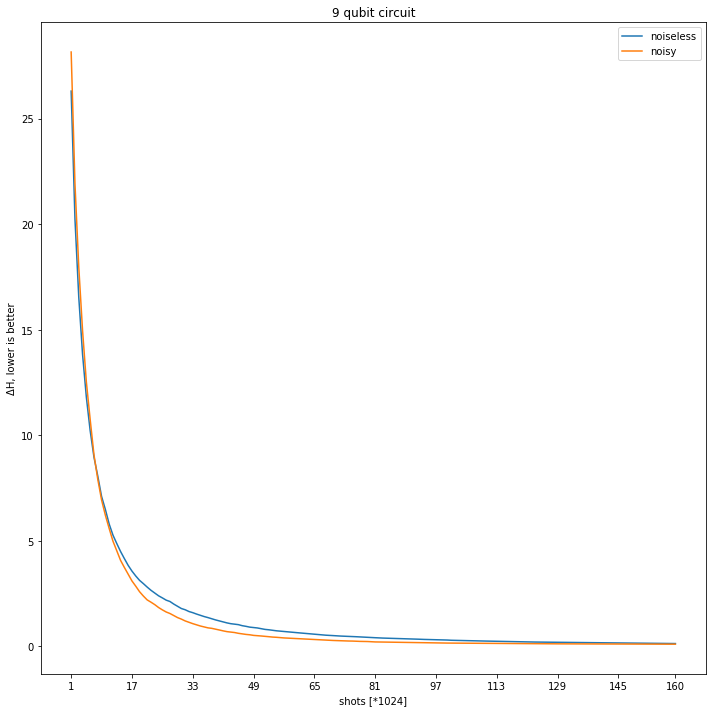

In [1]:
from qcg.generators import gen_supremacy, gen_hwea, gen_BV, gen_qft, gen_sycamore
import numpy as np
from utils.helper_fun import evaluate_circ, get_evaluator_info
import matplotlib.pyplot as plt
import math

def get_xticks(xvals):
    if len(xvals)<=10:
        return xvals
    else:
        x_ticks = []
        step = math.ceil(len(xvals)/10)
        for idx, x in enumerate(xvals):
            if idx%step==0 or idx==len(xvals)-1:
                x_ticks.append(x)
        return x_ticks

def make_plot(noiseless_ce_l,noisy_ce_l,full_circ_size,shots_increment):
    assert len(noiseless_ce_l) == len(noisy_ce_l)
    xvals = range(1,len(noiseless_ce_l)+1)
    plt.figure(figsize=(10,10))
    plt.plot(xvals,noiseless_ce_l,label='noiseless')
    plt.plot(xvals,noisy_ce_l,label='noisy')
    x_ticks = get_xticks(xvals=xvals)
    plt.xticks(ticks=x_ticks,labels=x_ticks)
    plt.ylabel('\u0394H, lower is better')
    plt.xlabel('shots [*%d]'%shots_increment)
    plt.title('%d qubit circuit'%(full_circ_size))
    plt.legend()
    plt.tight_layout()
    plt.show()

def cross_entropy(target,obs):
    assert len(target)==len(obs)
    epsilon = 1e-20
    obs = [abs(x) if x!=0 else epsilon for x in obs]
    sum_of_prob = sum(obs)
    obs = [x/sum_of_prob for x in obs]
    assert abs(sum(obs)-1) < 1e-10
    h = 0
    for p,q in zip(target,obs):
        if p==0:
            h += 0
        else:
            h += p*np.log(p/q)
    return h

def calculate_delta_H(circ,ground_truth,accumulated_prob,counter,shots_increment,evaluation_method):
    if evaluation_method == 'qasm_simulator':
        qasm_evaluator_info = {'num_shots':shots_increment}
        prob_batch = evaluate_circ(circ=circ,backend='noiseless_qasm_simulator',evaluator_info=qasm_evaluator_info)
    elif evaluation_method == 'noisy_qasm_simulator':
        qasm_noise_evaluator_info = get_evaluator_info(circ=circ,device_name='ibmq_boeblingen',
        fields=['device','basis_gates','coupling_map','properties','initial_layout','noise_model'])
        qasm_noise_evaluator_info['num_shots'] = shots_increment
        prob_batch = evaluate_circ(circ=circ,backend='noisy_qasm_simulator',evaluator_info=qasm_noise_evaluator_info)
    else:
        raise Exception('Illegal evaluation method:',evaluation_method)
    accumulated_prob = [(x*(counter-1)+y)/counter for x,y in zip(accumulated_prob,prob_batch)]
    assert abs(sum(accumulated_prob)-1)<1e-10
    accumulated_ce = cross_entropy(target=ground_truth,obs=accumulated_prob)
    return accumulated_ce, accumulated_prob

def circuit_decay(circuit,shots_increment):
    full_circ_size = len(circuit.qubits)
    ground_truth = evaluate_circ(circ=circuit,backend='statevector_simulator',evaluator_info=None)
    noiseless_accumulated_prob = [0 for i in range(np.power(2,full_circ_size))]
    noiseless_delta_H_l = []
    noisy_accumulated_prob = [0 for i in range(np.power(2,full_circ_size))]
    noisy_delta_H_l = []
    max_counter = max(20,int(20*np.power(2,full_circ_size)/shots_increment))
    for counter in range(1,max_counter+1):
        print(counter)
        noiseless_accumulated_ce, noiseless_accumulated_prob = calculate_delta_H(circ=circuit,ground_truth=ground_truth,
        accumulated_prob=noiseless_accumulated_prob,counter=counter,shots_increment=shots_increment,evaluation_method='qasm_simulator')
        noiseless_delta_H_l.append(noiseless_accumulated_ce)

        noisy_accumulated_ce, noisy_accumulated_prob = calculate_delta_H(circ=circuit,ground_truth=ground_truth,
        accumulated_prob=noisy_accumulated_prob,counter=counter,shots_increment=shots_increment,evaluation_method='noisy_qasm_simulator')
        noisy_delta_H_l.append(noisy_accumulated_ce)
        
    return noiseless_delta_H_l, noisy_delta_H_l

circ = gen_supremacy(1,13,8)
noiseless_delta_H_l, noisy_delta_H_l = circuit_decay(circuit=circ,shots_increment=1024)
make_plot(noiseless_ce_l=noiseless_delta_H_l,noisy_ce_l=noisy_delta_H_l,full_circ_size=9,shots_increment=1024)